## Certified privacy- and unlearning-safe training on the OCT-MNIST dataset

Run over different privacy and unlearning parameters and plot the results

In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import copy
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

import abstract_gradient_training as agt
from abstract_gradient_training import AGTConfig
from abstract_gradient_training import model_utils
from labellines import *

sys.path.append('..')
from models.deepmind import DeepMindSmall 
from datasets import oct_mnist

In [2]:
results_dir = ".results/"
seed = 3
notebook_id = f"oct_sweep_poison_{seed}"
# model_path = ".models/medmnist_robust_eps0.01_alpha0.1_meps0.01.ckpt"  # pretrained model path
model_path = ".models/medmnist_robust_eps0.5_alpha0.3_meps0.001.ckpt"
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

### Define the nominal config, model and dataloaders

In [3]:
class poisoned_dataloader:
    def __init__(self, dataloader, label_k_poison):
        self.dataloader = dataloader
        self.label_k_poison = label_k_poison
        self.poisoned_dataloader = self._poison_dataloader()
    
    def _poison_dataloader(self):
        poisoned_dataloader = []
        for x, y in self.dataloader:
            # randomly choose a subset of the data to poison
            idx = torch.randperm(len(y))[:self.label_k_poison]
            y[idx] = 1 - y[idx]
            poisoned_dataloader.append((x, y))
        return poisoned_dataloader

    def __iter__(self):
        return iter(self.poisoned_dataloader)
    
    def __len__(self):
        return len(self.poisoned_dataloader)

In [5]:
torch.manual_seed(0)

clean_batchsize = 3000
drusen_batchsize = 3000
test_batchsize = 1000

nominal_config = AGTConfig(
    fragsize=2000,
    learning_rate=0.05,
    label_k_poison=1000,
    n_epochs=2,
    forward_bound="interval",
    device="cuda:0",
    backward_bound="interval",
    loss="binary_cross_entropy",
    log_level="DEBUG",
    lr_decay=5.0,
    lr_min=0.001,
    early_stopping=False,
)

# get dataloaders
dl_clean, dl_test_clean = oct_mnist.get_dataloaders(clean_batchsize, test_batchsize, exclude_classes=[2])
dl_drusen, dl_test_drusen = oct_mnist.get_dataloaders(drusen_batchsize, test_batchsize, exclude_classes=[0, 1, 3])
_, dl_test_all = oct_mnist.get_dataloaders(clean_batchsize, test_batchsize)

# get the "DeepMindSmall" model, pretrained on the MedMNIST dataset (without class 2, Drusen)
model = DeepMindSmall(1, 1)
model.load_state_dict(torch.load(model_path))
model = model.to(nominal_config.device)

conv_layers = model[0:5]
linear_layers = model[5:-1]
conv_transform = model_utils.get_conv_model_transform(conv_layers)
param_l, param_n, param_u = model_utils.get_parameters(linear_layers)

# evaluate the pre-trained model
param_l, param_n, param_u = model_utils.get_parameters(linear_layers)
drusen_acc = agt.test_metrics.test_accuracy(
    param_l, param_n, param_u, *next(iter(dl_test_drusen)), transform=conv_transform
)
pretrained_acc_backdoor = agt.test_metrics.test_accuracy(
    param_l, param_n, param_u, *next(iter(dl_test_drusen)), transform=conv_transform, epsilon=0.001
)
pretrained_acc = drusen_acc[1]
clean_acc = agt.test_metrics.test_accuracy(
    param_l, param_n, param_u, *next(iter(dl_test_clean)), transform=conv_transform
)
all_acc = agt.test_metrics.test_accuracy(param_l, param_n, param_u, *next(iter(dl_test_all)), transform=conv_transform)

print("=========== Pre-trained model accuracy ===========", file=sys.stderr)
print(f"Class 2 (Drusen) : nominal = {drusen_acc[1]:.2g}", file=sys.stderr)
print(f"Classes 0, 1, 3  : nominal = {clean_acc[1]:.2g}", file=sys.stderr)
print(f"All Classes      : nominal = {all_acc[1]:.2g}", file=sys.stderr)

=========== Pre-trained model accuracy ===========
Class 2 (Drusen) : nominal = 0.37
Classes 0, 1, 3  : nominal = 0.83
All Classes      : nominal = 0.71


In [7]:
# fine-tune the model using abstract gradient training (keeping the convolutional layers fixed)
conf = copy.deepcopy(nominal_config)
param_l, param_n, param_u = agt.poison_certified_training(
    linear_layers, conf, dl_drusen, dl_test_drusen, dl_clean=dl_clean, transform=conv_transform
)

[AGT] [INFO    ] [17:04:09] =================== Starting Poison Certified Training ===================
[AGT] [DEBUG   ] [17:04:09] 	Optimizer params: n_epochs=2, learning_rate=0.05, l1_reg=0.0, l2_reg=0.0
[AGT] [DEBUG   ] [17:04:09] 	Learning rate schedule: lr_decay=5.0, lr_min=0.001, early_stopping=False
[AGT] [DEBUG   ] [17:04:09] 	Adversary feature-space budget: epsilon=0, k_poison=0
[AGT] [DEBUG   ] [17:04:09] 	Adversary label-space budget: label_epsilon=0, label_k_poison=1000, poison_target=-1
[AGT] [DEBUG   ] [17:04:09] 	Clipping: gamma=inf, method=clamp
[AGT] [DEBUG   ] [17:04:09] 	Bounding methods: forward=interval, loss=binary_cross_entropy, backward=interval
[AGT] [INFO    ] [17:04:09] Starting epoch 1
[AGT] [DEBUG   ] [17:04:09] Initialising dataloader batchsize to 6000
[AGT] [INFO    ] [17:04:09] Training batch 1: Network eval bounds=(0.37, 0.37, 0.37), W0 Bound=0.0 
[AGT] [INFO    ] [17:04:11] Training batch 2: Network eval bounds=(0.47, 0.93, 0.94), W0 Bound=0.104 
[AGT] 

In [8]:
# fine-tune the model using abstract gradient training (keeping the convolutional layers fixed)
conf = copy.deepcopy(nominal_config)
conf.label_k_poison = 100
dl_drusen_poisoned = poisoned_dataloader(dl_drusen, conf.label_k_poison)
param_l, param_n, param_u = agt.poison_certified_training(
    linear_layers, conf, dl_drusen_poisoned, dl_test_drusen, dl_clean=dl_clean, transform=conv_transform
)

[AGT] [INFO    ] [17:04:26] =================== Starting Poison Certified Training ===================
[AGT] [DEBUG   ] [17:04:26] 	Optimizer params: n_epochs=2, learning_rate=0.05, l1_reg=0.0, l2_reg=0.0
[AGT] [DEBUG   ] [17:04:26] 	Learning rate schedule: lr_decay=5.0, lr_min=0.001, early_stopping=False
[AGT] [DEBUG   ] [17:04:26] 	Adversary feature-space budget: epsilon=0, k_poison=0
[AGT] [DEBUG   ] [17:04:26] 	Adversary label-space budget: label_epsilon=0, label_k_poison=100, poison_target=-1
[AGT] [DEBUG   ] [17:04:26] 	Clipping: gamma=inf, method=clamp
[AGT] [DEBUG   ] [17:04:26] 	Bounding methods: forward=interval, loss=binary_cross_entropy, backward=interval
[AGT] [INFO    ] [17:04:26] Starting epoch 1
[AGT] [DEBUG   ] [17:04:26] Initialising dataloader batchsize to 6000
[AGT] [INFO    ] [17:04:26] Training batch 1: Network eval bounds=(0.37, 0.37, 0.37), W0 Bound=0.0 
[AGT] [INFO    ] [17:04:27] Training batch 2: Network eval bounds=(0.88, 0.92, 0.94), W0 Bound=0.0212 
[AGT] 

In [13]:
cert_accs = []
poison_accs = []

for k in range(0, 1001, 50):
    conf = copy.deepcopy(nominal_config)
    conf.label_k_poison = k
    # clean run
    torch.manual_seed(seed)
    param_l, param_n, param_u = agt.poison_certified_training(
        linear_layers, conf, dl_drusen, dl_test_drusen, dl_clean=dl_clean, transform=conv_transform
    )
    cert_accs.append(
        agt.test_metrics.test_accuracy(
            param_l, param_n, param_u, *next(iter(dl_test_drusen)), transform=conv_transform
        )[0]
    )

    # poisoned run
    torch.manual_seed(seed)
    dl_drusen_poisoned = poisoned_dataloader(dl_drusen, conf.label_k_poison)
    param_l, param_n, param_u = agt.poison_certified_training(
        linear_layers, conf, dl_drusen_poisoned, dl_test_drusen, dl_clean=dl_clean, transform=conv_transform
    )
    poison_accs.append(
        agt.test_metrics.test_accuracy(
            param_l,
            param_n,
            param_u,
            *next(iter(dl_test_drusen)),
            transform=conv_transform
        )[1]
    )

[AGT] [INFO    ] [16:29:45] =================== Starting Poison Certified Training ===================
[AGT] [DEBUG   ] [16:29:45] 	Optimizer params: n_epochs=2, learning_rate=0.05, l1_reg=0.0, l2_reg=0.0
[AGT] [DEBUG   ] [16:29:45] 	Learning rate schedule: lr_decay=5.0, lr_min=0.001, early_stopping=False
[AGT] [DEBUG   ] [16:29:45] 	Adversary feature-space budget: epsilon=0, k_poison=0
[AGT] [DEBUG   ] [16:29:45] 	Adversary label-space budget: label_epsilon=0, label_k_poison=0, poison_target=-1
[AGT] [DEBUG   ] [16:29:45] 	Clipping: gamma=inf, method=clamp
[AGT] [DEBUG   ] [16:29:45] 	Bounding methods: forward=interval, loss=binary_cross_entropy, backward=interval
[AGT] [INFO    ] [16:29:45] Starting epoch 1
[AGT] [DEBUG   ] [16:29:45] Initialising dataloader batchsize to 6000
[AGT] [INFO    ] [16:29:45] Training batch 1: Network eval bounds=(0.37, 0.37, 0.37), W0 Bound=0.0 
[AGT] [INFO    ] [16:29:45] Training batch 2: Network eval bounds=(0.94, 0.94, 0.94), W0 Bound=0.0 
[AGT] [DEBU

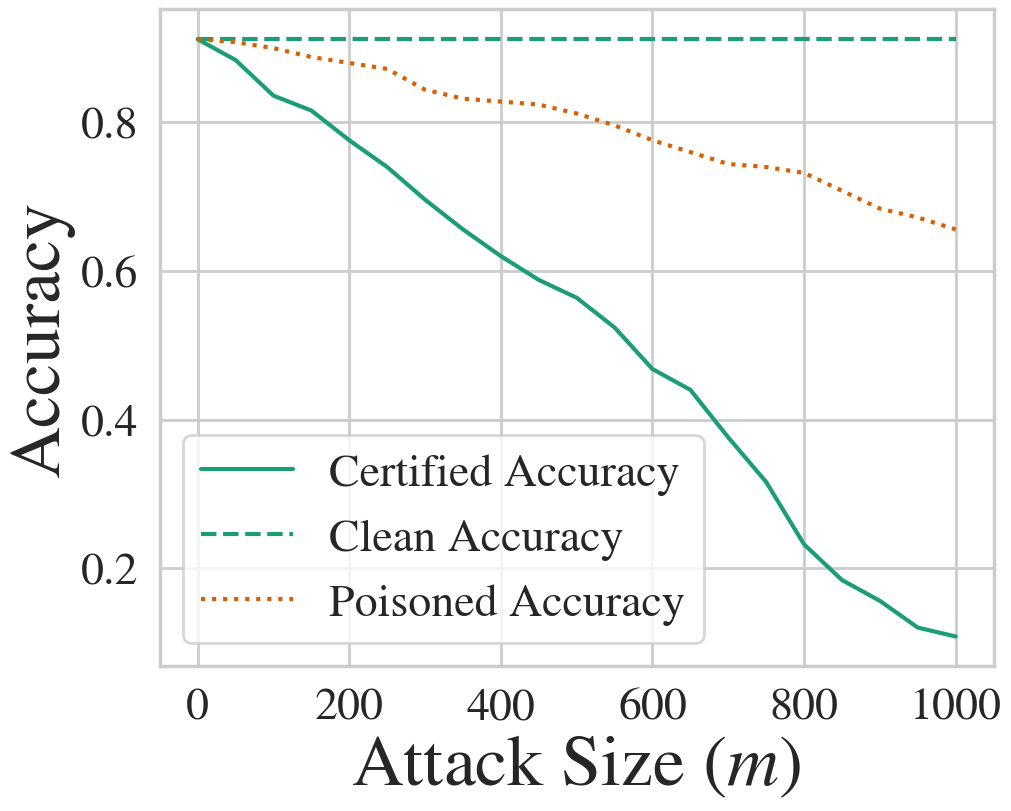

In [14]:
palette = sns.color_palette(palette="Dark2", n_colors=12)
lb_color = list(iter(sns.color_palette(palette="deep")))[-1]
ub_color = list(iter(sns.color_palette(palette="deep")))[-2]

sns.set_theme(context="poster", style="whitegrid", font_scale=1.5)
mpl.rcParams["mathtext.fontset"] = "stix"
mpl.rcParams["font.family"] = "STIXGeneral"
labelsize = 22

fig, ax = plt.subplots(
    1,
    1,
    figsize=(10, 8),
    layout="constrained",
)

# ax.set_title("Random Label Flipping Attack ")

colors = iter(palette)
nom_accs = [cert_accs[0] for _ in cert_accs]
poison_accs[0] = cert_accs[0]
color = next(colors)
ax.plot(range(0, 1001, 50), cert_accs, color=color, label="Certified Accuracy")
ax.plot(range(0, 1001, 50), nom_accs, color=color, linestyle="--", label="Clean Accuracy")
color = next(colors)
ax.plot(range(0, 1001, 50), poison_accs, color=color, label="Poisoned Accuracy", linestyle=":")

ax.set_ylabel("Accuracy", fontsize="x-large")
ax.set_xlabel("Attack Size ($m$)", fontsize="x-large")
ax.legend(loc="lower left")

plt.savefig(f".figures/oct_mnist_rand_flips.pdf", bbox_inches="tight", dpi=300)